We get the necessary code from the previous tasks

In [1]:
# Importing necessary libraries 

import pandas as pd
import matplotlib.pyplot as plt
import glob

# Load and concatenate all files into a single DataFrame
# Here I was using the same approach as in Task1 but the code was too resource-intensive for my computer, so I had ChatGPT optimizing it and it is slightly different, and faster
DATA_PATH = "./data/PhysicalFlows_12.1.G"
pattern_flow = f'{DATA_PATH}/*_PhysicalFlows_12.1.G.csv'
data_flow = [pd.read_csv(file, sep='\t', parse_dates=["DateTime"]) for file in glob.glob(pattern_flow)]
df_flow = pd.concat(data_flow, axis=0)

# Filter for Germany data with specified MapCodes
df_flow_germany = df_flow.query("InMapCode in ['DE_LU'] and OutMapCode in ['NO2']")

# Ensure the data is sorted by 'DateTime'
df_flow_germany = df_flow_germany.sort_values('DateTime').set_index('DateTime')

# Group by weekly periods and sum the 'FlowValue' column
# Here I was taking the first 162 rows and combining them in a sum using the function "lambda" (there are 162 hours in a week) but ChatGPT recommended me to use the function resample, which would be cleaner and more efficient
df_germany_weekly = df_flow_germany.resample('W').sum(numeric_only=True)


# Filter for Norway data with specified MapCodes
df_flow_norway = df_flow.query("InMapCode in ['NO2'] and OutMapCode in ['DE_LU']")

# Ensure the data is sorted by 'DateTime'
df_flow_norway = df_flow_norway.sort_values('DateTime').set_index('DateTime')

# Group by weekly periods and sum the 'FlowValue' column
df_norway_weekly = df_flow_norway.resample('W').sum(numeric_only=True)


# Now we combine the dataframes to show the flow and whether it is positive or negative

# Calculate the net flow: Germany to Norway minus Norway to Germany
df_net_flow_weekly = df_germany_weekly['FlowValue'] - df_norway_weekly['FlowValue']




DATA_PATH = './data/DayAheadPrices_12.1.D'

pattern = f'{DATA_PATH}/*_DayAheadPrices_12.1.D.csv'

# Loop through each file, read it into a DataFrame, and store it in a list

data = []

for file in glob.glob(pattern):
    df = pd.read_csv(file, sep = '\t', parse_dates= ['DateTime'])
    data.append(df)

# Combine all files into a single DataFrame

df= pd.concat(data, axis = 0)

# Filter data to keep only hourly (PT60M) records for Southern Norway (NO2) and Germany (DE_LU) 
df_filtered = df.query("MapCode in ['NO2', 'DE_LU'] and ResolutionCode == 'PT60M'")

# Reshape data to create separate columns for each price zone and rename columns for clarity
df_reshaped = df_filtered.pivot(index='DateTime', columns='MapCode', values='Price')

df_reshaped.columns = ['NO2 Price' if col == 'NO2' else 'Germany Price' for col in df_reshaped.columns]

# Step 1: Filter Data
df_filtered = df[(df['MapCode'].isin(['NO2', 'DE_LU'])) & (df['ResolutionCode'] == 'PT60M')]

# Step 2: Reshape Data
df_pivot = df_filtered.pivot(index='DateTime', columns='MapCode', values='Price')
df_pivot.columns = ['NO2 Price' if col == 'NO2' else 'Germany Price' for col in df_pivot.columns]

# Step 3: Define Nordlink opening date
nordlink_opening_date = pd.to_datetime('2020-12-09')





In [32]:
Now we can proceed with Task 5

SyntaxError: invalid syntax (1019663433.py, line 1)

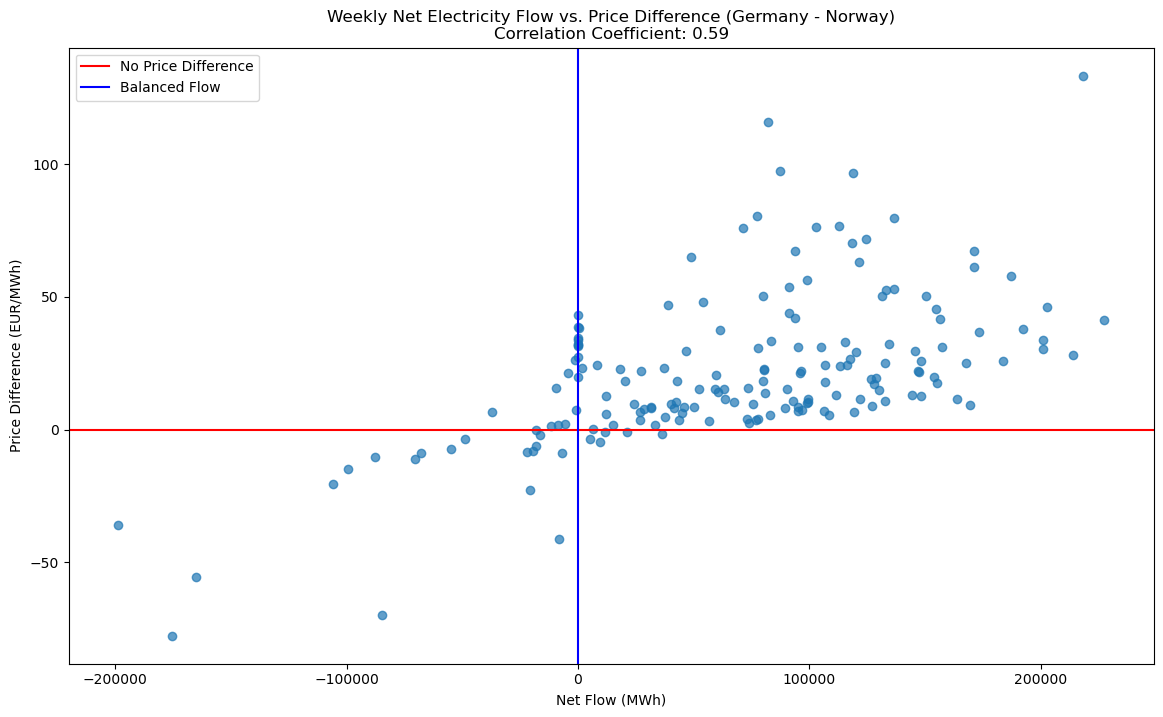

In [29]:
# We need to get the price again of Norway and Germany

df_price_germany = df_filtered.query("MapCode == 'DE_LU'")
df_price_norway = df_filtered.query("MapCode == 'NO2'")


# The price is every hour, we need to change it weekly
# Again, I was using a lambda function like in Task 4 but I tried the resample method that ChatGPT recommended, and works better
# We need to make sure that only numbers are being summed if we want to avoid errors

df_price_germany = df_price_germany.set_index('DateTime').resample('W').mean(numeric_only=True)
df_price_norway = df_price_norway.set_index('DateTime').resample('W').mean(numeric_only=True)


# Now we calculate the price difference

df_price_diff_weekly = df_price_germany['Price'] - df_price_norway['Price']


# Now that we have our suitable data, it is easier if we combine them in one single dataframe rather than plotting data from two different dataframes
df_weekly_data = pd.DataFrame({
    'Net Flow': df_net_flow_weekly,
    'Price Difference': df_price_diff_weekly
}).dropna()  # Avoids rows with missing data, as recommended by ChatGPT


# We calculate the correlation coefficient in the way that ChatGPT proposed

correlation_coefficient = df_weekly_data['Net Flow'].corr(df_weekly_data['Price Difference'])


# With our data ready we can create a scatter plot

plt.figure(figsize=(14, 8))
plt.scatter(df_weekly_data['Net Flow'], df_weekly_data['Price Difference'], alpha=0.7)
plt.title(f"Weekly Net Electricity Flow vs. Price Difference (Germany - Norway)\nCorrelation Coefficient: {correlation_coefficient:.2f}")
plt.xlabel("Net Flow (MWh)")
plt.ylabel("Price Difference (EUR/MWh)")
plt.axhline(0, color='red', label="No Price Difference")
plt.axvline(0, color='blue', label="Balanced Flow")
plt.legend()
plt.savefig('figure_task5.png')
plt.show()